# Train Networks

- Train a deep classifier for the EEG-based diagnostic classification
    - CAUEEG-abnormal benchmark: Classification of **Normal** and **Abnormal** symptoms
    - CAUEEG-dementia benchmark: Classification of **Normal**, **MCI**, and **Dementia** symptoms

-----

## Load Packages

In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%cd ..

C:\Users\Minjae\Desktop\EEG_Project


In [2]:
# Load some packages
import hydra
from omegaconf import OmegaConf
import wandb
import pprint

# custom package
from run_train import check_device_env
from run_train import prepare_and_run_train

---

## Specify the dataset, model, and train setting

In [3]:
project = 'caueeg-dementia'
data_cfg_file = 'caueeg-dementia'
train_cfg_file = 'tiny-train'
model_cfg_file = '1D-VGG-16'
device = 'cuda:0'

---

## Initializing configurations using Hydra

In [4]:
with hydra.initialize(config_path='../config'):
    add_configs = [f"data={data_cfg_file}", 
                   f"train={train_cfg_file}", 
                   f"+train.device={device}", 
                   f"+train.project={project}",
                   f"model={model_cfg_file}",]
    
    cfg = hydra.compose(config_name='default', overrides=add_configs)
    
config = {**OmegaConf.to_container(cfg.data), 
          **OmegaConf.to_container(cfg.train),
          **OmegaConf.to_container(cfg.model)}

check_device_env(config)
pprint.pprint(config)

{'EKG': 'O',
 '_target_': 'models.vgg_1d.VGG1D',
 'activation': 'mish',
 'awgn': 0.001,
 'awgn_age': 0.001,
 'base_lr': 0.0001,
 'batch_norm': True,
 'criterion': 'cross-entropy',
 'crop_multiple': 4,
 'crop_timing_analysis': False,
 'dataset_path': 'local/dataset/02_Curated_Data_220419/',
 'ddp': False,
 'device': device(type='cuda', index=0),
 'draw_result': True,
 'dropout': 0.3,
 'fc_stages': 3,
 'file_format': 'memmap',
 'in_channels': '???',
 'input_norm': 'dataset',
 'latency': 2000,
 'load_event': False,
 'lr_scheduler_type': 'constant_with_decay',
 'mgn': 0.001,
 'minibatch': 512,
 'mixup': 0.0,
 'model': '1D-VGG-16',
 'num_history': 5,
 'out_dims': '???',
 'photic': 'X',
 'project': 'sweep-test',
 'run_mode': 'train',
 'save_model': False,
 'search_lr': False,
 'search_multiplier': 1.0,
 'seed': 0,
 'seq_length': 2000,
 'signal_length_limit': 10000000,
 'task': 'dementia',
 'test_crop_multiple': 8,
 'total_samples': 100000,
 'use_age': 'fc',
 'use_wandb': False,
 'warmup_min'

## Train

39 /     195 iter - Loss: 1.057, Train Acc.: 46.62, Val. Acc.: 52.3
78 /     195 iter - Loss: 0.9831, Train Acc.: 50.33, Val. Acc.: 50.91
117 /     195 iter - Loss: 0.9395, Train Acc.: 53.65, Val. Acc.: 55.17
156 /     195 iter - Loss: 0.9101, Train Acc.: 56.02, Val. Acc.: 55.29
195 /     195 iter - Loss: 0.8911, Train Acc.: 56.75, Val. Acc.: 55.71

******************************         2022_0922_2007         ******************************

{'(Best, Last) Test Accuracy': ('Last', 61.43, 62.02),
 'Confusion Matrix (Array)': array([[4972,  387,  161],
       [2086, 1738, 1096],
       [ 529, 1119, 2072]]),
 'Multi-Crop Test Accuracy': 63.53107344632768,
 'Test Accuracy': 62.01977401129943}

********************************************************************************************



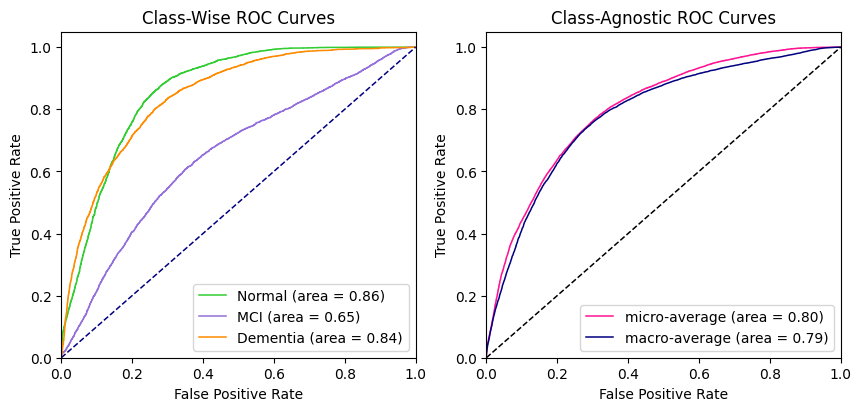

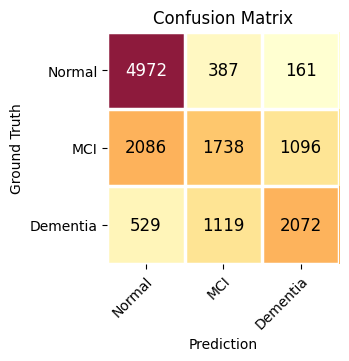

In [5]:
prepare_and_run_train(rank=None, world_size=None, config=config)